In [1]:
import os,re,sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
%matplot inline 

UsageError: Line magic function `%matplot` not found.


In [2]:
os.chdir("C:/Users/user/Desktop/Capstone")


In [3]:
%time dataset = pd.read_table('XYZCorp_LendingDataa.txt', parse_dates=['issue_d'], low_memory=False)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


Wall time: 1min 3s


In [4]:
dataset.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
dataset.shape

(855969, 73)

In [6]:
dataset['default_ind'].value_counts()/len(dataset)

0    0.945714
1    0.054286
Name: default_ind, dtype: float64

In [7]:
#checking missing value
dataset.isnull().sum()


id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       49443
emp_length                      43061
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
pymnt_plan                          0
desc                           734157
purpose                             0
title                              33
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_line                    0
inq_last_6mths                      0
mths_since_l

In [8]:
def check_missing_data(dataset):
    flag=dataset.isna().sum().any()
    if flag==True:
        total = dataset.isnull().sum()
        percent = round((dataset.isnull().sum())/(dataset.isnull().count()),3)*100
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in dataset.columns:
            dtype = str(dataset[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)
    
check_missing_data(dataset)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
Total,0,0,0,0,0,0,0,0,0,0,...,844360,842681,842681,842681,842681,67313,842681,842681,842681,0
Percent,0,0,0,0,0,0,0,0,0,0,...,98.6,98.4,98.4,98.4,98.4,7.9,98.4,98.4,98.4,0
Types,int64,int64,float64,float64,float64,object,float64,float64,object,object,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


In [9]:
dataset['default_ind'].value_counts()

0    809502
1     46467
Name: default_ind, dtype: int64

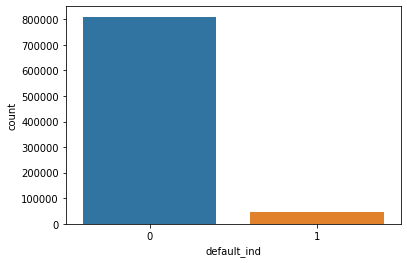

In [10]:
sns.countplot('default_ind',data=dataset)

In [11]:
#treating missing value

lis = dataset.isnull().sum()

for i in range (len(lis)):
    if lis[i]>800000:
        del dataset['{}'.format(lis.index[i])]

In [12]:
dataset.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       49443
emp_length                      43061
home_ownership                      0
annual_inc                          0
verification_status                 0
issue_d                             0
pymnt_plan                          0
desc                           734157
purpose                             0
title                              33
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                         0
earliest_cr_line                    0
inq_last_6mths                      0
mths_since_l

In [13]:
dataset[dataset.columns].corr()['default_ind'][:]

id                            -0.219832
member_id                     -0.220181
loan_amnt                     -0.004907
funded_amnt                   -0.005797
funded_amnt_inv               -0.008209
int_rate                       0.155037
installment                    0.004753
annual_inc                    -0.037066
dti                            0.004429
delinq_2yrs                   -0.009186
inq_last_6mths                 0.074407
mths_since_last_delinq         0.001317
mths_since_last_record         0.061484
open_acc                      -0.021698
pub_rec                       -0.019607
revol_bal                     -0.020696
revol_util                     0.044497
total_acc                     -0.021087
out_prncp                     -0.225960
out_prncp_inv                 -0.225959
total_pymnt                   -0.039220
total_pymnt_inv               -0.040232
total_rec_prncp               -0.090336
total_rec_int                  0.046050
total_rec_late_fee             0.140760


In [14]:
dataset.shape

(855969, 56)

In [15]:
lis=dataset[dataset.columns].corr()['default_ind'][:]
dataset[dataset.columns].corr()['default_ind'][:]

id                            -0.219832
member_id                     -0.220181
loan_amnt                     -0.004907
funded_amnt                   -0.005797
funded_amnt_inv               -0.008209
int_rate                       0.155037
installment                    0.004753
annual_inc                    -0.037066
dti                            0.004429
delinq_2yrs                   -0.009186
inq_last_6mths                 0.074407
mths_since_last_delinq         0.001317
mths_since_last_record         0.061484
open_acc                      -0.021698
pub_rec                       -0.019607
revol_bal                     -0.020696
revol_util                     0.044497
total_acc                     -0.021087
out_prncp                     -0.225960
out_prncp_inv                 -0.225959
total_pymnt                   -0.039220
total_pymnt_inv               -0.040232
total_rec_prncp               -0.090336
total_rec_int                  0.046050
total_rec_late_fee             0.140760


In [16]:
dataset.info()
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 56 columns):
id                             855969 non-null int64
member_id                      855969 non-null int64
loan_amnt                      855969 non-null float64
funded_amnt                    855969 non-null float64
funded_amnt_inv                855969 non-null float64
term                           855969 non-null object
int_rate                       855969 non-null float64
installment                    855969 non-null float64
grade                          855969 non-null object
sub_grade                      855969 non-null object
emp_title                      806526 non-null object
emp_length                     812908 non-null object
home_ownership                 855969 non-null object
annual_inc                     855969 non-null float64
verification_status            855969 non-null object
issue_d                        855969 non-null datetime64[ns]
pymnt_plan   

# Removing list with low correlation

In [17]:
lis2 = []
for i in range(len(lis)):
    if lis[i]<0.02 and lis[i]>(-0.02):
        lis2.append(lis.index[i])   

In [18]:
print(lis2)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 'pub_rec', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt']


In [19]:
for i in range(len(lis2)):
    del dataset['{}'.format(lis2[i])]

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 44 columns):
id                         855969 non-null int64
member_id                  855969 non-null int64
term                       855969 non-null object
int_rate                   855969 non-null float64
grade                      855969 non-null object
sub_grade                  855969 non-null object
emp_title                  806526 non-null object
emp_length                 812908 non-null object
home_ownership             855969 non-null object
annual_inc                 855969 non-null float64
verification_status        855969 non-null object
issue_d                    855969 non-null datetime64[ns]
pymnt_plan                 855969 non-null object
desc                       121812 non-null object
purpose                    855969 non-null object
title                      855936 non-null object
zip_code                   855969 non-null object
addr_state                 8559

In [21]:
dataset.shape

(855969, 44)

In [22]:
dataset['application_type'].value_counts()

INDIVIDUAL    855527
JOINT            442
Name: application_type, dtype: int64

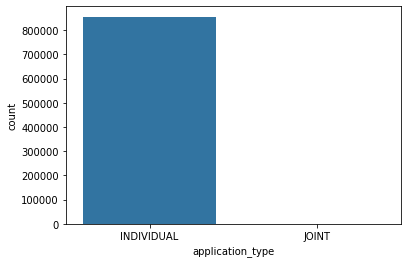

In [23]:
sns.countplot('application_type',data=dataset)

In [24]:
df = dataset.groupby('application_type')
df['default_ind'].value_counts()

application_type  default_ind
INDIVIDUAL        0              809060
                  1               46467
JOINT             0                 442
Name: default_ind, dtype: int64

In [25]:
dataset['application_type'] = np.where(dataset['application_type']=='INDIVIDUAL',0,dataset['application_type'])
dataset['application_type'] = np.where(dataset['application_type']=='JOINT',1,dataset['application_type'])

In [26]:
dataset['application_type'].value_counts()

0    855527
1       442
Name: application_type, dtype: int64

In [27]:
dataset['application_type'] = dataset['application_type'].astype(float)

In [28]:
dataset['verification_status'].value_counts()

Source Verified    318178
Verified           280049
Not Verified       257742
Name: verification_status, dtype: int64

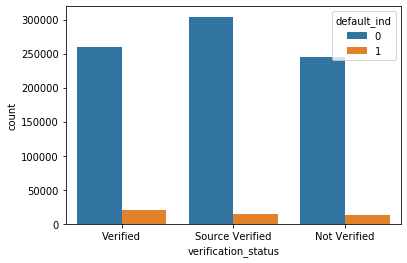

In [29]:
sns.countplot('verification_status',data=dataset, hue= 'default_ind')

In [30]:
#dummies 
ds = pd.get_dummies(dataset['verification_status'],drop_first=True)
dataset = pd.concat([ds,dataset],axis=1)
del dataset['verification_status']

# Intial _list_status

In [31]:
dataset['initial_list_status'].value_counts()

f    442555
w    413414
Name: initial_list_status, dtype: int64

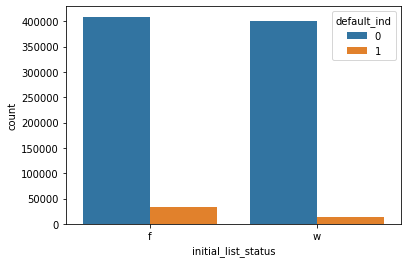

In [32]:
sns.countplot('initial_list_status',data=dataset,hue='default_ind')

In [33]:
dataset['initial_list_status'] = np.where(dataset['initial_list_status']=='f',0,dataset['initial_list_status'])
dataset['initial_list_status'] = np.where(dataset['initial_list_status']=='w',1,dataset['initial_list_status'])

In [34]:
dataset['initial_list_status'].value_counts()

0    442555
1    413414
Name: initial_list_status, dtype: int64

In [35]:
dataset['initial_list_status'] = dataset['initial_list_status'].astype(float)

# Term 

In [36]:
dataset['term'].value_counts()

 36 months    600221
 60 months    255748
Name: term, dtype: int64

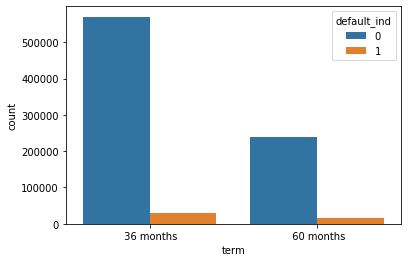

In [37]:
sns.countplot('term', data=dataset ,hue='default_ind')

In [38]:
dataset['term'] = np.where(dataset['term']==' 36 months',0,dataset['term'])
dataset['term'] = np.where(dataset['term']==' 60 months',1, dataset['term'])

In [39]:
dataset['term'].value_counts()

0    600221
1    255748
Name: term, dtype: int64

In [40]:
dataset['term'] = dataset['term'].astype(float)

# Grade

In [41]:
dataset['grade'].value_counts()

B    247998
C    236855
A    145665
D    132802
E     66448
F     21328
G      4873
Name: grade, dtype: int64

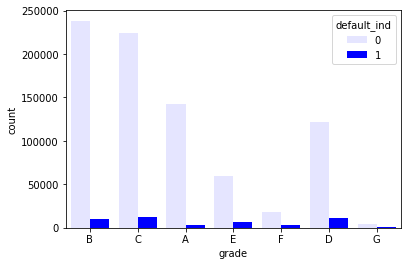

In [42]:
sns.countplot('grade' , data=dataset, hue = 'default_ind',color = 'blue',saturation = 1)

In [43]:
dataset['grade'] = np.where(dataset['grade']=='A',0,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='B',0,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='C',0,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='D',1,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='E',1,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='F',1,dataset['grade'])
dataset['grade'] = np.where(dataset['grade']=='G',1,dataset['grade'])

In [44]:
dataset['grade'].value_counts()

0    630518
1    225451
Name: grade, dtype: int64

In [45]:
dataset['grade'] = dataset['grade'].astype(float)

# Home_Ownership

In [46]:
dataset['home_ownership'].value_counts()

MORTGAGE    429106
RENT        342535
OWN          84136
OTHER          144
NONE            45
ANY              3
Name: home_ownership, dtype: int64

In [47]:
dg = dataset.groupby('home_ownership')
dg['default_ind'].value_counts()

home_ownership  default_ind
ANY             0                   3
MORTGAGE        0              408730
                1               20376
NONE            0                  38
                1                   7
OTHER           0                 117
                1                  27
OWN             0               80001
                1                4135
RENT            0              320613
                1               21922
Name: default_ind, dtype: int64

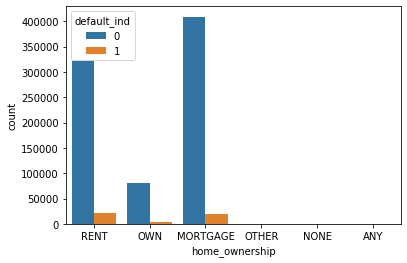

In [48]:
sns.countplot('home_ownership',data=dataset,hue='default_ind')

In [49]:
dataset['home_ownership'] = np.where(dataset['home_ownership']=='RENT',1,dataset['home_ownership'])
dataset['home_ownership'] = np.where(dataset['home_ownership']=='OWN',1,dataset['home_ownership'])
dataset['home_ownership'] = np.where(dataset['home_ownership']=='MORTGAGE',1,dataset['home_ownership'])
dataset['home_ownership'] = np.where(dataset['home_ownership']=='OTHER',2,dataset['home_ownership'])
dataset['home_ownership'] = np.where(dataset['home_ownership']=='NONE',2,dataset['home_ownership'])
dataset['home_ownership'] = np.where(dataset['home_ownership']=='ANY',0,dataset['home_ownership'])

In [50]:
dataset['home_ownership'].value_counts()

1    855777
2       189
0         3
Name: home_ownership, dtype: int64

In [51]:
dw = pd.get_dummies(dataset['home_ownership'],drop_first=True)
dataset = pd.concat([dw,dataset],axis=1)
del dataset['home_ownership']

In [52]:
dataset['pymnt_plan'].value_counts()

n    855964
y         5
Name: pymnt_plan, dtype: int64

In [53]:
del dataset['pymnt_plan']

In [54]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 45 columns):
1                          855969 non-null uint8
2                          855969 non-null uint8
Source Verified            855969 non-null uint8
Verified                   855969 non-null uint8
id                         855969 non-null int64
member_id                  855969 non-null int64
term                       855969 non-null float64
int_rate                   855969 non-null float64
grade                      855969 non-null float64
sub_grade                  855969 non-null object
emp_title                  806526 non-null object
emp_length                 812908 non-null object
annual_inc                 855969 non-null float64
issue_d                    855969 non-null datetime64[ns]
desc                       121812 non-null object
purpose                    855969 non-null object
title                      855936 non-null object
zip_code                   855969

# last_credit_pull_d

In [55]:
dataset['last_credit_pull_d'] = pd.to_datetime(dataset['last_credit_pull_d'])
dataset['Month'] = dataset['last_credit_pull_d'].apply(lambda x: x.month)
dataset['Year']  = dataset['last_credit_pull_d'].apply(lambda x: x.year)


In [56]:
dataset = dataset.drop(['last_credit_pull_d'], axis =1)

In [57]:
dataset.dtypes

1                                   uint8
2                                   uint8
Source Verified                     uint8
Verified                            uint8
id                                  int64
member_id                           int64
term                              float64
int_rate                          float64
grade                             float64
sub_grade                          object
emp_title                          object
emp_length                         object
annual_inc                        float64
issue_d                    datetime64[ns]
desc                               object
purpose                            object
title                              object
zip_code                           object
addr_state                         object
earliest_cr_line                   object
inq_last_6mths                    float64
mths_since_last_record            float64
open_acc                          float64
revol_bal                         

In [58]:
dataset = dataset.drop(['next_pymnt_d', 'last_pymnt_d', 'earliest_cr_line','desc','purpose','title','zip_code','addr_state','sub_grade','emp_title','emp_length'],axis=1)

In [59]:
dataset.shape

(855969, 35)

In [60]:
dataset.dtypes

1                                   uint8
2                                   uint8
Source Verified                     uint8
Verified                            uint8
id                                  int64
member_id                           int64
term                              float64
int_rate                          float64
grade                             float64
annual_inc                        float64
issue_d                    datetime64[ns]
inq_last_6mths                    float64
mths_since_last_record            float64
open_acc                          float64
revol_bal                         float64
revol_util                        float64
total_acc                         float64
initial_list_status               float64
out_prncp                         float64
out_prncp_inv                     float64
total_pymnt                       float64
total_pymnt_inv                   float64
total_rec_prncp                   float64
total_rec_int                     

In [61]:
dataset.isnull().sum()

1                               0
2                               0
Source Verified                 0
Verified                        0
id                              0
member_id                       0
term                            0
int_rate                        0
grade                           0
annual_inc                      0
issue_d                         0
inq_last_6mths                  0
mths_since_last_record     724785
open_acc                        0
revol_bal                       0
revol_util                    446
total_acc                       0
initial_list_status             0
out_prncp                       0
out_prncp_inv                   0
total_pymnt                     0
total_pymnt_inv                 0
total_rec_prncp                 0
total_rec_int                   0
total_rec_late_fee              0
recoveries                      0
collection_recovery_fee         0
last_pymnt_amnt                 0
policy_code                     0
application_ty

In [62]:
del dataset['mths_since_last_record']
del dataset['id']
del dataset['member_id']
del dataset['tot_cur_bal']
del dataset['total_rev_hi_lim']
del dataset['policy_code']

In [63]:
dataset.shape

(855969, 29)

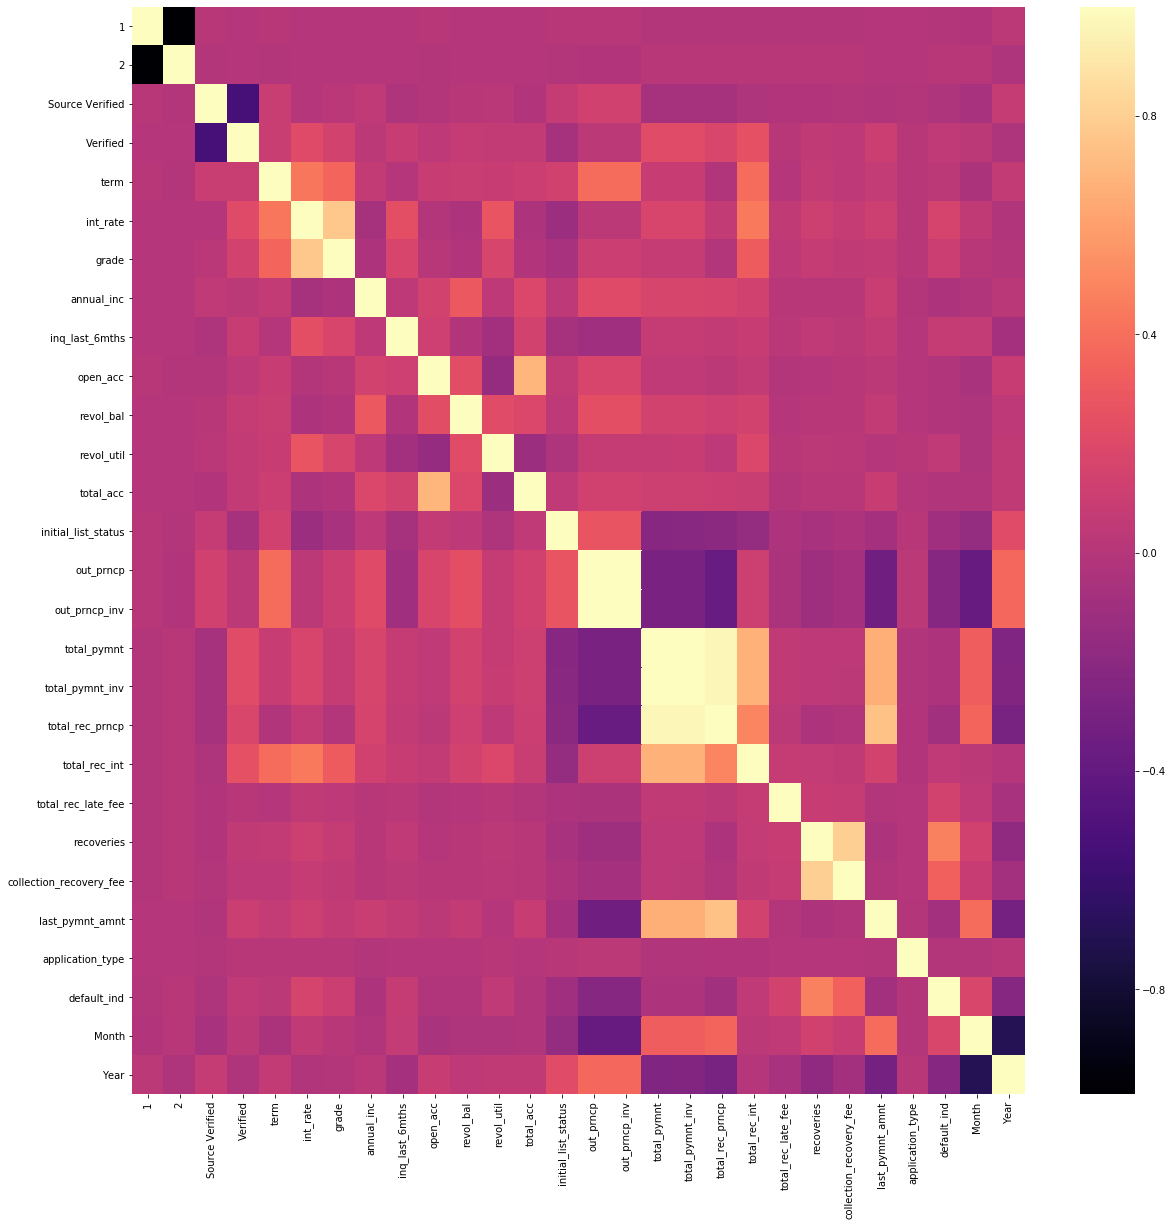

In [64]:
plt.figure(figsize=(20,20))
sns.heatmap(dataset.corr(), cmap = 'magma')

In [65]:
dataset.columns

Index([                        1,                         2,
               'Source Verified',                'Verified',
                          'term',                'int_rate',
                         'grade',              'annual_inc',
                       'issue_d',          'inq_last_6mths',
                      'open_acc',               'revol_bal',
                    'revol_util',               'total_acc',
           'initial_list_status',               'out_prncp',
                 'out_prncp_inv',             'total_pymnt',
               'total_pymnt_inv',         'total_rec_prncp',
                 'total_rec_int',      'total_rec_late_fee',
                    'recoveries', 'collection_recovery_fee',
               'last_pymnt_amnt',        'application_type',
                   'default_ind',                   'Month',
                          'Year'],
      dtype='object')

In [66]:
dataset['revol_util'].fillna(dataset['revol_util'].mean(),inplace=True)
dataset['Month'].fillna(dataset.mode()['Month'][0],inplace=True)
dataset['Year'].fillna(dataset.mode()['Year'][0],inplace=True)

In [67]:
dataset.shape

(855969, 29)

In [68]:
dataset['last'] = dataset['default_ind']
del dataset['default_ind']
dataset['default_ind'] = dataset['last']
del dataset['last']

In [69]:
dataset.columns

Index([                        1,                         2,
               'Source Verified',                'Verified',
                          'term',                'int_rate',
                         'grade',              'annual_inc',
                       'issue_d',          'inq_last_6mths',
                      'open_acc',               'revol_bal',
                    'revol_util',               'total_acc',
           'initial_list_status',               'out_prncp',
                 'out_prncp_inv',             'total_pymnt',
               'total_pymnt_inv',         'total_rec_prncp',
                 'total_rec_int',      'total_rec_late_fee',
                    'recoveries', 'collection_recovery_fee',
               'last_pymnt_amnt',        'application_type',
                         'Month',                    'Year',
                   'default_ind'],
      dtype='object')

In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 29 columns):
1                          855969 non-null uint8
2                          855969 non-null uint8
Source Verified            855969 non-null uint8
Verified                   855969 non-null uint8
term                       855969 non-null float64
int_rate                   855969 non-null float64
grade                      855969 non-null float64
annual_inc                 855969 non-null float64
issue_d                    855969 non-null datetime64[ns]
inq_last_6mths             855969 non-null float64
open_acc                   855969 non-null float64
revol_bal                  855969 non-null float64
revol_util                 855969 non-null float64
total_acc                  855969 non-null float64
initial_list_status        855969 non-null float64
out_prncp                  855969 non-null float64
out_prncp_inv              855969 non-null float64
total_pymnt            

In [71]:
dataset.describe()

,1,2,Source Verified,Verified,term,int_rate,grade,annual_inc,inq_last_6mths,open_acc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,application_type,Month,Year,default_ind
count,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,8.559690e+05,855969.000000,855969.000000,...,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000
mean,0.999776,0.000221,0.371717,0.327172,0.298782,13.192320,0.263387,7.507119e+04,0.680915,11.542447,...,5850.841088,1755.046221,0.319530,47.089499,4.951227,2225.985295,0.000516,2.191089,2015.719162,0.054286
std,0.014975,0.014858,0.483264,0.469181,0.457724,4.368365,0.440471,6.426447e+04,0.964033,5.308094,...,6676.410888,2081.692980,3.609399,413.136043,62.478569,4864.966593,0.022718,2.932581,0.729346,0.226581
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.320000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2007.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,9.990000,0.000000,4.500000e+04,0.000000,8.000000,...,1239.950000,451.270000,0.000000,0.000000,0.000000,285.420000,0.000000,1.000000,2016.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,12.990000,0.000000,6.500000e+04,0.000000,11.000000,...,3286.890000,1076.910000,0.000000,0.000000,0.000000,468.820000,0.000000,1.000000,2016.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,15.990000,1.000000,9.000000e+04,1.000000,14.000000,...,8000.000000,2233.980000,0.000000,0.000000,0.000000,849.160000,0.000000,1.000000,2016.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,28.990000,1.000000,9.500000e+06,8.000000,90.000000,...,35000.030000,24205.620000,358.680000,33520.270000,7002.190000,36475.590000,1.000000,12.000000,2016.000000,1.000000


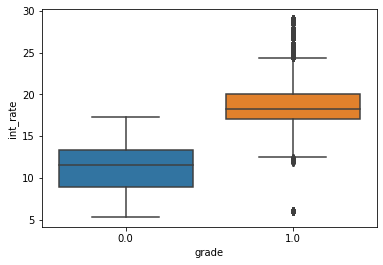

In [72]:
sns.boxplot('grade' , 'int_rate', data = dataset)

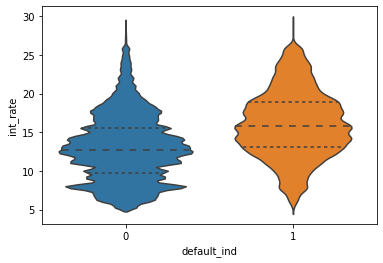

In [73]:
sns.violinplot('default_ind','int_rate',data=dataset,bw='scott',inner='quartile')

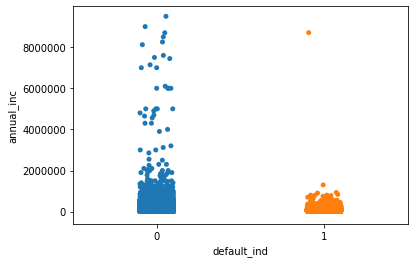

In [74]:
sns.stripplot('default_ind','annual_inc',data=dataset,jitter=True)

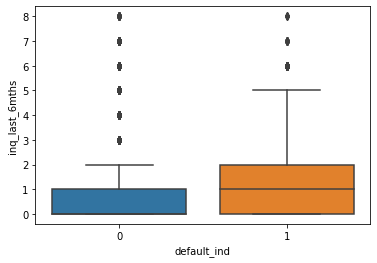

In [75]:
sns.boxplot('default_ind','inq_last_6mths',data=dataset)

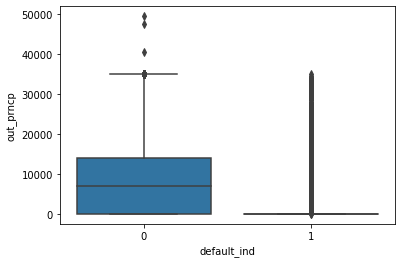

In [76]:
sns.boxplot('default_ind','out_prncp',data=dataset)

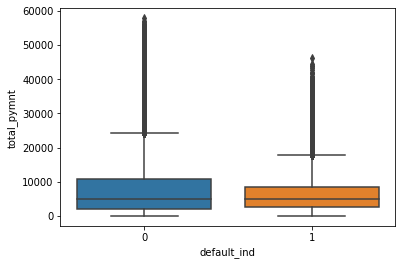

In [77]:
sns.boxplot('default_ind','total_pymnt',data=dataset)

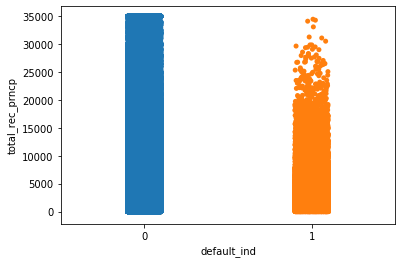

In [78]:
sns.stripplot('default_ind','total_rec_prncp',data=dataset,jitter=True)

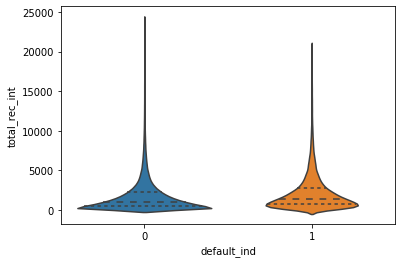

In [79]:
sns.violinplot('default_ind','total_rec_int',data=dataset,inner='quartile')

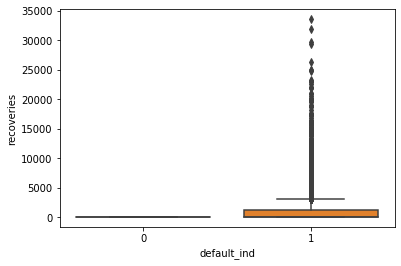

In [80]:
sns.boxplot('default_ind','recoveries',data=dataset)

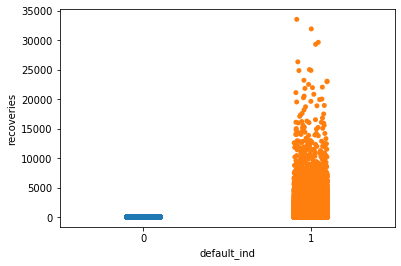

In [81]:
sns.stripplot('default_ind','recoveries',data=dataset,jitter=True)

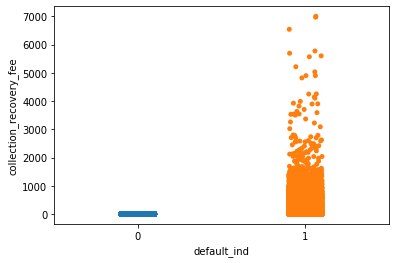

In [82]:
sns.stripplot('default_ind','collection_recovery_fee',data=dataset,jitter=True)

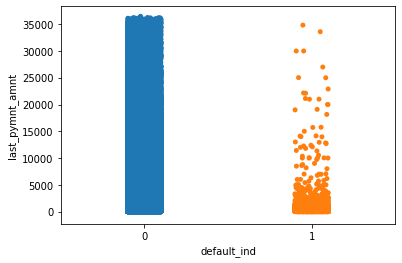

In [83]:
sns.stripplot('default_ind','last_pymnt_amnt',data=dataset,jitter=True)

In [84]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 29 columns):
1                          855969 non-null uint8
2                          855969 non-null uint8
Source Verified            855969 non-null uint8
Verified                   855969 non-null uint8
term                       855969 non-null float64
int_rate                   855969 non-null float64
grade                      855969 non-null float64
annual_inc                 855969 non-null float64
issue_d                    855969 non-null datetime64[ns]
inq_last_6mths             855969 non-null float64
open_acc                   855969 non-null float64
revol_bal                  855969 non-null float64
revol_util                 855969 non-null float64
total_acc                  855969 non-null float64
initial_list_status        855969 non-null float64
out_prncp                  855969 non-null float64
out_prncp_inv              855969 non-null float64
total_pymnt            

In [85]:
train = dataset[dataset['issue_d'] < '2015-6-01']
test = dataset[dataset['issue_d']>= '2015-6-01']

In [86]:
del dataset['issue_d']

In [87]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 46)

In [89]:
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
from sklearn.metrics import accuracy_score
print ("Logistic testing accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test))

Logistic testing accuracy is 0.98


In [92]:
print(confusion_matrix(y_test,model.predict(X_test)))

[[161706    155]
 [  2464   6869]]


In [93]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    161861
           1       0.98      0.74      0.84      9333

    accuracy                           0.98    171194
   macro avg       0.98      0.87      0.92    171194
weighted avg       0.98      0.98      0.98    171194



In [94]:
classifier2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=666)

In [95]:
classifier2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=666,
                       verbose=0, warm_start=False)

In [96]:
y_pred = classifier2.predict(X_test)

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161861
           1       1.00      0.94      0.97      9333

    accuracy                           1.00    171194
   macro avg       1.00      0.97      0.98    171194
weighted avg       1.00      1.00      1.00    171194



In [1]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier2, X = X_train, y = y_train, cv=10)

NameError: name 'classifier2' is not defined

In [107]:
accuracies.mean()

0.9966456126800134

In [108]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(684775, 27) (171194, 27) (684775,) (171194,)


In [109]:
modelxgb = XGBClassifier()
modelxgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [110]:
y_predboost = modelxgb.predict(X_test)

In [111]:
print(classification_report(y_test,y_predboost))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    161861
           1       0.99      0.91      0.95      9333

    accuracy                           0.99    171194
   macro avg       0.99      0.96      0.97    171194
weighted avg       0.99      0.99      0.99    171194

